In [1]:

import os, pickle
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


In [6]:

def process_results(results_dir, perturb_type):
    df, flat_pvals = [], []
    rates = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    run2rate = {i+1: r for i, r in enumerate(rates)}

    for fname in os.listdir(results_dir):
        parts = fname[:-2].split('-')
        run_num = int(parts[2])
        rate = run2rate[run_num]
        results = pickle.load(open(os.path.join(results_dir, fname), 'rb'))
        info = vars(results['args'])
        info['run_num'] = run_num
        info[f'{perturb_type}_rate'] = rate

        wm_pvals = torch.Tensor([float(p) for p in results['watermark']['pvals']])
        null_pvals = torch.Tensor([float(p) for p in results['null']['pvals']])
        wm_tim = torch.Tensor(results['watermark']['tim'])
        null_tim = torch.Tensor(results['null']['tim'])

        alpha = info['alpha']
        info['power'] = (wm_pvals <= alpha).float().mean().item()
        info['null_rejection_rate'] = (null_pvals <= alpha).float().mean().item()
        info[f'watermark_median_n_perms'] = wm_tim.median().item()
        info[f'null_median_n_perms'] = null_tim.median().item()

        df.append(info)

        for p in wm_pvals:
            flat_pvals.append({'rate': rate, 'type': 'watermark', 'pval': float(p), 'perturb': perturb_type})
        for p in null_pvals:
            flat_pvals.append({'rate': rate, 'type': 'null', 'pval': float(p), 'perturb': perturb_type})

    return pd.DataFrame(df), pd.DataFrame(flat_pvals)


In [7]:

df_del, flat_del = process_results("results/exp-del", "deletion")
df_sub, flat_sub = process_results("results/exp-sub", "substitution")
df_ins, flat_ins = process_results("results/exp-ins", "insertion")

df_all = pd.concat([df_del, df_sub, df_ins], ignore_index=True)
flat_all = pd.concat([flat_del, flat_sub, flat_ins], ignore_index=True)


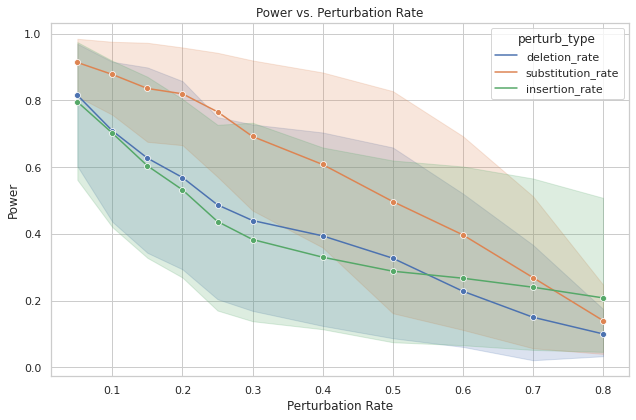

In [8]:

melted = df_all.melt(
    id_vars=['run_num', 'power', 'null_rejection_rate', 'watermark_median_n_perms', 'null_median_n_perms'],
    value_vars=['deletion_rate', 'substitution_rate', 'insertion_rate'],
    var_name='perturb_type', value_name='rate'
).dropna()

plt.figure(figsize=(9, 6))
sns.lineplot(data=melted, x='rate', y='power', hue='perturb_type', marker='o')
plt.title("Power vs. Perturbation Rate")
plt.xlabel("Perturbation Rate")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_power_vs_rate.png", dpi=600)
plt.show()


AttributeError: 'Line2D' object has no property 'errorbar'

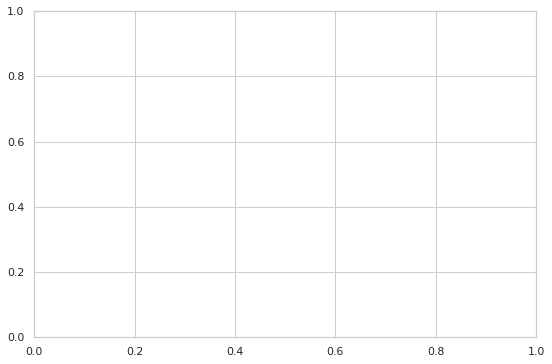

In [ ]:

# plt.figure(figsize=(9, 6))
# sns.lineplot(
#     data=flat_all,
#     x='rate',
#     y='pval',
#     hue='perturb',
#     style='type',
#     estimator='median',
#     errorbar='sd',
#     marker='o'
# )
# plt.title("Median p-value vs Perturbation Rate")
# plt.ylabel("Median p-value")
# plt.xlabel("Perturbation Rate")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("combined_pval_vs_rate.png", dpi=600)
# plt.show()
plt.figure(figsize=(9, 6))

sns.lineplot(
    data=flat_all,
    x='rate',
    y='pval',
    hue='perturb',
    style='type',
    markers=True,  # 老版用 markers=True，marker='o'是新版写法
    dashes=False,
    ci='sd',  # 老版 seaborn 是 ci，表示 error band 显示 standard deviation
    estimator='median'
)

plt.title("Median p-value vs Perturbation Rate")
plt.ylabel("Median p-value")
plt.xlabel("Perturbation Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_pval_vs_rate.png", dpi=600)
plt.show()

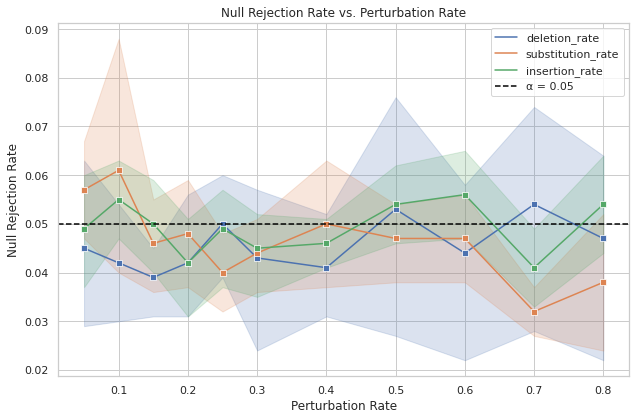

In [10]:

plt.figure(figsize=(9, 6))
sns.lineplot(data=melted, x='rate', y='null_rejection_rate', hue='perturb_type', marker='s')
plt.axhline(0.05, linestyle='--', color='black', label='α = 0.05')
plt.title("Null Rejection Rate vs. Perturbation Rate")
plt.xlabel("Perturbation Rate")
plt.ylabel("Null Rejection Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_nullrate_vs_rate.png", dpi=600)
plt.show()


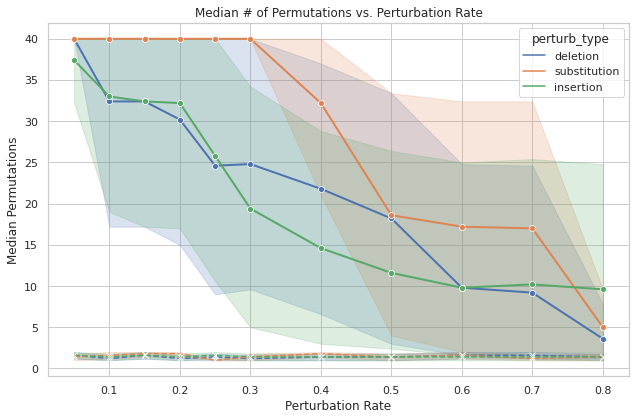

In [11]:
# === 修复版：构造统一格式的 perm_df ===
perm_del = df_del[['deletion_rate', 'watermark_median_n_perms', 'null_median_n_perms']].copy()
perm_del['perturb_type'] = 'deletion'

perm_sub = df_sub[['substitution_rate', 'watermark_median_n_perms', 'null_median_n_perms']].copy()
perm_sub['perturb_type'] = 'substitution'

perm_ins = df_ins[['insertion_rate', 'watermark_median_n_perms', 'null_median_n_perms']].copy()
perm_ins['perturb_type'] = 'insertion'

# 重命名统一 rate 列名
perm_del = perm_del.rename(columns={'deletion_rate': 'rate'})
perm_sub = perm_sub.rename(columns={'substitution_rate': 'rate'})
perm_ins = perm_ins.rename(columns={'insertion_rate': 'rate'})

# 合并
perm_df = pd.concat([perm_del, perm_sub, perm_ins], ignore_index=True)

# === 画图 ===
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=perm_df,
    x='rate',
    y='watermark_median_n_perms',
    hue='perturb_type',
    marker='o',
    linewidth=2
)

sns.lineplot(
    data=perm_df,
    x='rate',
    y='null_median_n_perms',
    hue='perturb_type',
    marker='x',
    linestyle='--',
    legend=False  # 避免重复图例
)

plt.title("Median # of Permutations vs. Perturbation Rate")
plt.xlabel("Perturbation Rate")
plt.ylabel("Median Permutations")
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_median_perms_vs_rate_fixed.png", dpi=600)
plt.show()

